In [33]:
import os
import pandas as pd
import praw

In [34]:
from dotenv import load_dotenv

In [ ]:
your_reddit_username = "<enter your username here>"

In [ ]:
user_agent = "Scraper 1.0 by /u/yourUsername"
reddit = praw.Reddit (
client_id="",
client_secret="",
user_agent=user_agent
)

In [ ]:
from nltk.corpus import wordnet as wn
from word_forms.word_forms import get_word_forms
# "public", "infrastructure", "planning", "urban", "civil",
keyword_list = {"transport", "traffic", "travel", "transit", "experience", "commute", "urban", "civil", "accelerate", "rule", "etiquette", "confuse", "empathy", "application", 
                "device", "digital", "facility", "design", "captain", "jam", "booking", "crossing", "crowd", "walkway", "linkway", "signal", 
                "route", "path", "destination", "bridge", "flyover", "overhead", "barrier", "stuffy", "spacious", "service", "breakdown", "bunching", "replace", "uncomfortable", 
                "journey", "network", "challenge", "recommendation", "suggestion", "affordable", "connectivity", "available", "condition", "speed", "fast", "slow", "smooth", 
                "stress", "welfare", "frequency", "certainty", "uncertainty", "licence", "COE", "management", "rail", "double decker", "operator", "elevator", 
                "escalator", "equipment", "brake", "disruption", "accident", "incident", "fatality", "dangerous", "roadworks", "construction", "deploy", "manpower", "expansion", 
                "extension", "incentive", "child-friendly", "family", "stroller", "pram", "luggage", "baggage", "baby", "pregnant", "infant", "molest", "harassment", 
                "family-friendly", "signage", "announcement", "visibility", "communication", "display", "aware", "behaviour", "navigation", "advisory", "update", "risk", 
                "warning", "injury", "hazard", "assist", "guide", "concession", "sticker", "board", "toilet", "provision", "accommodate", "information", "real-time", "handicap", 
                "hurry", "emergency", "wheelchair", "user", "peak-hour", "difficulty", "infrastructure", "institution", "authority", "ministry", "shuttle", "SBS", 
                "station", "platform", "technology", "engineering", "upgrade", "concern", "need", "grievance", "pain point", "problem", "solution", "delay", "stop", 
                "rush", "wait", "queue", "interchange", "development", "road", "lane", "street", "highway", "expressway", "causeway", "boulevard", "avenue", "bus", "car", "train", 
                "taxi", "cab", "vehicle", "truck", "bike", "bicycle", "motor", "vehicle", "metro", "MRT", "mass rapid transit", "SMRT", "LRT", "light rail transit", "drive", 
                "walk", "ride", "cycle", "park", "arrival", "departure", "duration", "comfort", "quality", "efficiency", "convenience", "regularity", "reliability", "punctual", 
                "timely", "inclusivity", "accessibility", "disability", "EZ-Link", "TransitLink", "simplygo", "CEPAS", "ERP", "electronic road pricing", "maintain", "improve", 
                "seats", "safety", "LTA", "land transport authority", "ticket", "pedestrian", "passenger", "patron", "commuter", "intersection", "demand", "expectation", "system", 
                "innovation", "governance", "PTC", "public transport council" "congestion", "fare", "fuel", "petrol", "diesel", "gas", "mobility", "distance", "mode", "trip"}
for word in keyword_list.copy():
    word_forms = get_word_forms(word, similarity_threshold=0.8)
    for key in word_forms:
        for form in word_forms[key]:
            keyword_list.add(form)

In [ ]:
keyword_list= ['"' + s + '"' for s in keyword_list]
keyword_list = ', '.join(keyword_list)

In [ ]:
subreddits = reddit.subreddit("singapore+asksingapore+singaporehappenings+drivingsg")

# creating lists for storing scraped data
ids=[]
titles=[]
content=[]
comments=[]

# looping over posts and scraping it
chunk_size = 20
iter = 0
while iter <= len(keyword_list)-chunk_size+1: 
    for submission in subreddits.search(keyword_list[iter:iter+chunk_size], time_filter="all"):
        if submission.upvote_ratio > 0.7 and submission.score > 50 and submission.id not in ids: 
            ids.append(submission.id)
            titles.append(submission.title)
            content.append(submission.selftext[:min(len(submission.selftext), 2000)])
            submission_comments = []
            for comment in submission.comments:
                if isinstance(comment, praw.models.MoreComments):
                    continue
                if comment.score > 10: 
                    submission_comments.append(comment.body[:min(len(comment.body), 2000)])
            comments.append(submission_comments)

    iter = iter + chunk_size

In [ ]:
df = pd.DataFrame() 
df['id'] = ids
df['title'] = titles
df['content'] = content
df['comment'] = comments

df.to_csv('reddit_data.csv')
df.to_json('reddit_data.json')

In [ ]:
df.to_csv('reddit_data_binclass.csv')
df.to_json('reddit_data_binclass.json')

In [ ]:
import google.generativeai as genai
import pandas as pd
genai.configure(api_key=<api_key>)

prompt1 = """Your task is to distill the essence of a given reddit post into a concise summary capturing the key points and essential information, 
within a 10-word limit.\n
If the post is not related to the subject of transportation, simply output 'unrelated' without any text formatting.\n
If, however, the post is about transportation, extract the following information.\n
Summary\n
Category 1 - The most appropriate category for the type of post from the following: complaint, suggestion, praise, query, information/news. Do not make up any categories of your own. If you are unsure of the category, put the category as 'other'.\n 
Category 2 - The most appropriate category for the subject of the post from the following: bus service, train service, private transport, walk/cycle, policy/regulation, infrastructure/facilities/systems. Do not make up any categories of your own. If you are unsure of the category, put the category as 'other'.\n
Output the extracted  information in the following format: 'summary: <summary>\ncategory 1: <category 1>\ncategory 2: <category 2>'
"""

safety_settings = [
    {
        "category": "HARM_CATEGORY_DANGEROUS",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_NONE",
    },
]

model = genai.GenerativeModel("gemini-pro", safety_settings=safety_settings)

def generate_gemini_content(transcript_text, prompt, model):
    response = model.generate_content(prompt + transcript_text)
    return response.text

In [ ]:
summaries = list()
categories_1 = list()
categories_2 = list()
#df = df.iloc[:10].copy(deep=True)
for index, row in df.iterrows():
    #print(index)
    flag = False
    if not len(row["content"]) == 0:
        try: 
            output = generate_gemini_content(row["content"], prompt1, model)
        except:
            #print(f'error at {index}')
            df = df.drop(index)   
        else:
            #print(index)
            flag = True          
    elif not len(row["title"]) == 0:
        try: 
            output = generate_gemini_content(row["title"], prompt1, model)
        except:
            #print(f'error at {index}')
            df = df.drop(index)
        else:
            #print(index)
            flag = True
    if flag:
        if output.lower() == "unrelated":
            df = df.drop(index)
            continue
        output = output.split('\n')
        output = [i for i in output if i != '']
        print(f'{index}: {output}')
        flag = 0
        try:
            flag = 1
            summaries.append(output[0].split(':')[-1].strip())
            flag = 2
            categories_1.append(output[-2].split(':')[-1].strip())
            flag = 3
            categories_2.append(output[-1].split(':')[-1].strip()) 
        except:
            message = "couldn't generate"
            if flag == 1:
                summaries.append(message)
                categories_1.append(message)
                categories_2.append(message)
            if flag == 2:
                categories_1.append(message)
                categories_2.append(message)
            if flag == 3:
                categories_2.append(messgae)
        #categories_3.append(output[-1].split(':')[-1].lstrip())


In [ ]:
df["summary"] = summaries
df["category1"] = categories_1
df["category2"] = categories_2

In [ ]:
categories_3 = list()

cross_reference = {'bus service': ['frequency', 'punctuality', 'accessibility', 'affordability', 'quality', 'safety', 'connectivity', 'crowding', 'infrastructure/facilities'],
                  'train service': ['frequency', 'punctuality', 'accessibility', 'affordability', 'quality', 'safety', 'connectivity', 'crowding', 'infrastructure/facilities'],
                  'private transport': ['cost', 'parking', 'safety', 'traffic/congestion', 'connectivity'],
                  'walk/cycle': ['safety', 'infrastructure/facilities'],
                  'policy/regulation': ['enforcement', 'compliance', 'transparency/communication', 'impact'],
                  'other': 'other'
                  }

prompt2 = f"""Your task is to categorise social media content about transportation in Singapore. The input will be provided to you in following format:'content: <content>\ncategory: <category>'. 
You need to match the category to a key in the dictionary below and return the most suitable subcategory from the corresponding list in the following format: 'category: <category>'. 
Do not make up any new categories. If there is no key in the dictionary that matches the input return'other'.\n{cross_reference}"""

for index, row in df.iterrows():
    category = row["category2"]
    content = row["summary"]
    input = f'content: {content}\ncategory: {category}'
    try:
        output = generate_gemini_content(input, prompt2, model)
    except:
        categories_3.append("couldn't generate")
    else:
        categories_3.append(output.split(':')[-1])

In [ ]:
df["category3"] = categories_3

In [ ]:
df.to_csv('reddit_data_w_summary_categories.csv')
df.to_json('reddit_data_w_summary_categories.json')

In [22]:
df_obj = df.select_dtypes('object')
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [23]:
df

,Unnamed: 0,id,title,content,comment,summary,category1,category2,category3
0,47,zkxern,"Anyone from the 1990s to the 2000s , does anyo...",I may be bad at phrasing this but when I was a...,NaN,Pneumatic tube system used to transport docume...,information/news,other,other
1,52,15nfod0,Grab’s service delivery is poor across their d...,It’s a continuation from another thread - wher...,NaN,Grabfood service complaints about loyalty poin...,complaint,private transport,other
2,74,jwyfo6,"Inaugural Trip on the Jurong line, 1965. I sus...",NaN,NaN,"Jurong Line inaugural trip in 1965, possibly a...",information/news,train service,other
3,97,128plry,A food delivery guy on an e-bike almost hit my...,I suppose this is more of a rant than a discus...,NaN,Complaint about e-bike rider near miss on pede...,complaint,walk/cycle,safety
4,99,xoabzw,Rental car registrations up over 25% in first ...,NaN,NaN,Rental car registrations up 25% in first half ...,information/news,private transport,private transport
...,...,...,...,...,...,...,...,...,...
142,1074,ljp36x,Tanjong Pagar car crash brings area’s speeding...,NaN,NaN,Tanjong Pagar fatal car crash highlights speed...,information/news,private transport,private transport
143,1095,ls27tk,Jurong Island,I’m going for internship at Jurong Island. I w...,NaN,Jurong Island commute and amenities query,query,private transport,other
144,1161,10hf73v,S'pore's MRT map will look like this when Cros...,NaN,NaN,MRT map expansion with Cross Island Line phase...,information/news,train service,connectivity
145,1163,16nggyu,Car COE prices hit new record; premiums for la...,NaN,NaN,Car Certificate of Entitlement prices hit reco...,information/news,private transport,cost


### Report Generation

In [1]:
import pandas as pd

/Users/sriramkavita/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sriramkavita/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('data/reddit_data_w_summary_categories.csv')

In [24]:
df

,Unnamed: 0,id,title,content,comment,summary,category1,category2,category3
0,47,zkxern,"Anyone from the 1990s to the 2000s , does anyo...",I may be bad at phrasing this but when I was a...,NaN,Pneumatic tube system used to transport docume...,information/news,other,other
1,52,15nfod0,Grab’s service delivery is poor across their d...,It’s a continuation from another thread - wher...,NaN,Grabfood service complaints about loyalty poin...,complaint,private transport,other
2,74,jwyfo6,"Inaugural Trip on the Jurong line, 1965. I sus...",NaN,NaN,"Jurong Line inaugural trip in 1965, possibly a...",information/news,train service,other
3,97,128plry,A food delivery guy on an e-bike almost hit my...,I suppose this is more of a rant than a discus...,NaN,Complaint about e-bike rider near miss on pede...,complaint,walk/cycle,safety
4,99,xoabzw,Rental car registrations up over 25% in first ...,NaN,NaN,Rental car registrations up 25% in first half ...,information/news,private transport,private transport
...,...,...,...,...,...,...,...,...,...
142,1074,ljp36x,Tanjong Pagar car crash brings area’s speeding...,NaN,NaN,Tanjong Pagar fatal car crash highlights speed...,information/news,private transport,private transport
143,1095,ls27tk,Jurong Island,I’m going for internship at Jurong Island. I w...,NaN,Jurong Island commute and amenities query,query,private transport,other
144,1161,10hf73v,S'pore's MRT map will look like this when Cros...,NaN,NaN,MRT map expansion with Cross Island Line phase...,information/news,train service,connectivity
145,1163,16nggyu,Car COE prices hit new record; premiums for la...,NaN,NaN,Car Certificate of Entitlement prices hit reco...,information/news,private transport,cost


In [25]:
x = df["category1"].value_counts()

In [26]:
x.to_dict()

{'information/news': 68,
 'complaint': 55,
 'query': 13,
 'praise': 7,
 'other': 3,
 'suggestion': 1}

In [27]:
type(x)

pandas.core.series.Series

In [28]:
df["category2"].value_counts()

category2
bus service                                      45
train service                                    32
private transport                                31
walk/cycle                                        8
infrastructure/facilities/systems                 8
other                                             7
policy/regulation                                 6
bus service, train service                        3
taxi service                                      1
cycling/walk                                      1
border/customs                                    1
cycling                                           1
bus service, train service, policy/regulation     1
bus service/train service                         1
public transport                                  1
Name: count, dtype: int64

In [29]:
cross_reference = {'bus service': ['frequency', 'punctuality', 'accessibility', 'affordability', 'quality', 'safety', 'connectivity', 'crowding', 'infrastructure/facilities'],
                  'train service': ['frequency', 'punctuality', 'accessibility', 'affordability', 'quality', 'safety', 'connectivity', 'crowding', 'infrastructure/facilities'],
                  'private transport': ['cost', 'parking', 'safety', 'traffic/congestion', 'connectivity'],
                  'walk/cycle': ['safety', 'infrastructure/facilities'],
                  'policy/regulation': ['enforcement', 'compliance', 'transparency/communication', 'impact'],
                  'other': 'other'
                  }

In [30]:
for cat in cross_reference:
    print(df.loc[df['category2'] == cat]["category3"].value_counts())

category3
other                        19
bus service                   9
safety                        4
policy/regulation             4
infrastructure/facilities     3
quality                       3
accessibility                 2
affordability                 1
Name: count, dtype: int64
category3
other                        11
train service                 9
policy/regulation             4
connectivity                  2
frequency                     1
accessibility                 1
passenger behavior            1
infrastructure/facilities     1
safety                        1
crowding                      1
Name: count, dtype: int64
category3
other                                   10
private transport                        8
safety                                   6
cost                                     3
traffic/congestion                       2
private transport/traffic/congestion     1
private transport/safety                 1
Name: count, dtype: int64
category3
safet

Generate some plots as well

In [ ]:
df = pd.read_csv('reddit_data_w_summary_categories.csv')
df["category1"].value_counts()
df["category2"].value_counts()

cross_reference = {'bus service': ['frequency', 'punctuality', 'accessibility', 'affordability', 'quality', 'safety', 'connectivity', 'crowding', 'infrastructure/facilities'],
                  'train service': ['frequency', 'punctuality', 'accessibility', 'affordability', 'quality', 'safety', 'connectivity', 'crowding', 'infrastructure/facilities'],
                  'private transport': ['cost', 'parking', 'safety', 'traffic/congestion', 'connectivity'],
                  'walk/cycle': ['safety', 'infrastructure/facilities'],
                  'policy/regulation': ['enforcement', 'compliance', 'transparency/communication', 'impact'],
                  'other': 'other'
                  }

for cat in cross_reference:
    print(df.loc[df['category2'] == cat]["category3"].value_counts())

import matplotlib.pyplot as plt
labels = df["category2"].value_counts().keys()
sizes = df["category2"].value_counts()
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

([<matplotlib.patches.Wedge at 0x7f810903f310>,
 [Text(0.6293283175150932, 0.9021894860690975, 'bus service'),
  Text(-0.9466965428521582, 0.5601478873938309, 'train service'),
  Text(-0.7567636359528034, -0.7983162276313148, 'private transport'),
  Text(0.08220304670379441, -1.0969241811139974, 'walk/cycle'),
  Text(0.445261618815601, -1.0058539112662985, 'infrastructure/facilities/systems'),
  Text(0.7395309312479567, -0.8143058404110401, 'other'),
  Text(0.9345100975548355, -0.5802507023417136, 'policy/regulation'),
  Text(1.028196870577664, -0.3909107255298818, 'bus service, train service'),
  Text(1.0578187610575236, -0.3016943300009568, 'taxi service'),
  Text(1.0697439418628738, -0.2562184592250927, 'cycling/walk'),
  Text(1.0797150587533557, -0.21027456313410214, 'border/customs'),
  Text(1.0877138978378276, -0.16394656583911735, 'cycling'),
  Text(1.0937258479161656, -0.11731909307553123, 'bus service, train service, policy/regulation'),
  Text(1.0977399271690325, -0.070477317

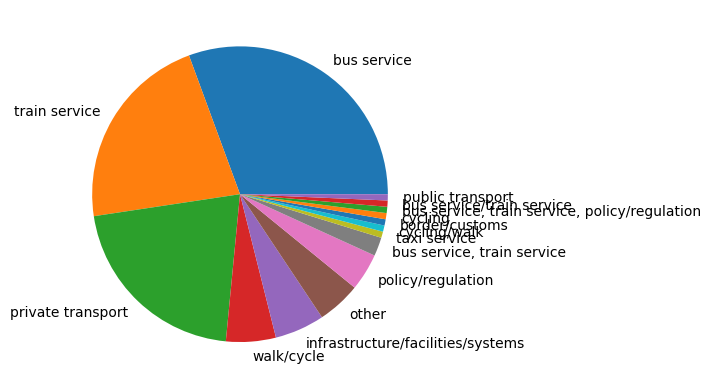

In [21]:
import matplotlib.pyplot as plt
labels = df["category2"].value_counts().keys()
sizes = df["category2"].value_counts()
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)